In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
import keras
from keras import ops
from keras import layers

2024-05-12 08:25:28.824194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 08:25:28.824341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 08:25:28.958503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!curl -LO https://raw.githubusercontent.com/shenasa-ai/iranian-car-license-plate/main/iclp-part1.zip
!unzip -qq iclp-part1.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.3M  100 20.3M    0     0  22.7M      0 --:--:-- --:--:-- --:--:-- 22.7M


In [3]:
base_path = '/kaggle/working/iclp-part1'
images = [os.path.join(base_path, path) for path in os.listdir(base_path)]
labels = [path.split('/')[4].split('_')[0] for path in images]
characters = sorted(list(set([char for label in labels for char in label])))

In [4]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  3000
Number of labels found:  3000
Number of unique characters:  26
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'H', 'J', 'K', 'L', 'M', 'N', 'S', 'T', 'V', 'X', 'Y', 'Z']


In [5]:
batch_size = 16
img_width = 256
img_height = 50
downsample_factor = 4
max_length = max([len(label) for label in labels])

In [6]:
char_to_num = layers.StringLookup(vocabulary=characters)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

In [7]:
char_to_num('K').numpy(), num_to_char(9).numpy()

(17, b'8')

In [8]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    indices = np.arange(len(images))
    if shuffle: np.random.shuffle(indices)
    x_train, y_train = images[indices[:int(train_size * len(images))]], labels[indices[:int(train_size * len(images))]]
    x_val, y_val = images[indices[int(train_size * len(images)):]], labels[indices[int(train_size * len(images)):]]
    return x_train, x_val, y_train, y_val

In [9]:
x_train, x_val, y_train, y_val = split_data(np.array(images), np.array(labels))

In [10]:
list(zip(*(x_train, y_train)))

[('/kaggle/working/iclp-part1/21K14917_15946.jpg', '21K14917'),
 ('/kaggle/working/iclp-part1/23X45661_4123.jpg', '23X45661'),
 ('/kaggle/working/iclp-part1/28J11815_4058.jpg', '28J11815'),
 ('/kaggle/working/iclp-part1/31K27635_1075.jpg', '31K27635'),
 ('/kaggle/working/iclp-part1/28Z56326_987.jpg', '28Z56326'),
 ('/kaggle/working/iclp-part1/26L34117_959.jpg', '26L34117'),
 ('/kaggle/working/iclp-part1/22B21522_7313.jpg', '22B21522'),
 ('/kaggle/working/iclp-part1/32L34525_6858.jpg', '32L34525'),
 ('/kaggle/working/iclp-part1/13D64337_3042.jpg', '13D64337'),
 ('/kaggle/working/iclp-part1/15L44616_5271.jpg', '15L44616'),
 ('/kaggle/working/iclp-part1/21M84515_4415.jpg', '21M84515'),
 ('/kaggle/working/iclp-part1/23L89935_9694.jpg', '23L89935'),
 ('/kaggle/working/iclp-part1/21Z49727_3008.jpg', '21Z49727'),
 ('/kaggle/working/iclp-part1/18Z54626_376.jpg', '18Z54626'),
 ('/kaggle/working/iclp-part1/29Z18226_1021.jpg', '29Z18226'),
 ('/kaggle/working/iclp-part1/14J99637_868.jpg', '14J9963

In [11]:
def encode_single_sample(img, label):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = ops.transpose(img, axes=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    return img, label

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

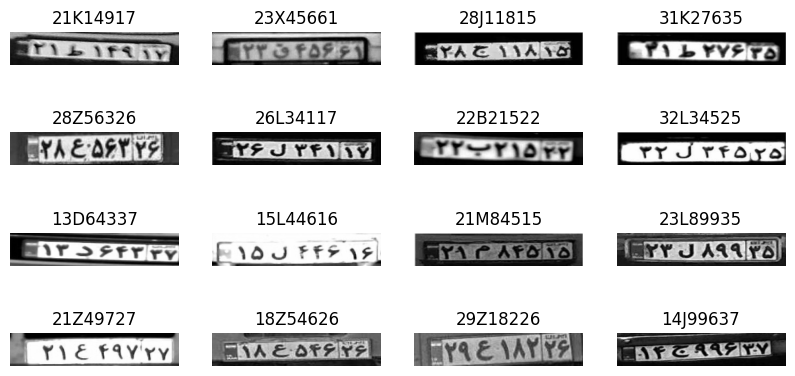

In [13]:
batch_data = next(iter(train_dataset))
images, labels = batch_data
_, axes = plt.subplots(4, 4, figsize=(10, 5))
for i in range(16):
    img = (images[i] * 255).numpy().astype('uint8')
    lbl = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode('UTF-8')
    axes[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
    axes[i // 4, i % 4].set_title(lbl)
    axes[i // 4, i % 4].axis('off')

In [14]:
new_shape = (img_width // 16, (img_height // 16) * 256)
nclasses = len(char_to_num.get_vocabulary())

model = keras.models.Sequential([
    layers.Input(shape=(img_width, img_height, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Reshape(target_shape=new_shape),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPool1D(2),
    layers.Dropout(0.5),
    layers.Dense(nclasses, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 6, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 3, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 16, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8, 27)          │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,667 (1.96 MB)

 Trainable params: 512,667 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs = 100
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, factor=0.1, )
]
metrics = ['accuracy',]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=metrics)

In [16]:
hitory = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 258ms/step - accuracy: 0.1701 - loss: 2.7382 - val_accuracy: 0.2542 - val_loss: 2.1585 - learning_rate: 0.0010
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 263ms/step - accuracy: 0.2976 - loss: 2.1048 - val_accuracy: 0.5825 - val_loss: 1.3146 - learning_rate: 0.0010
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 255ms/step - accuracy: 0.5582 - loss: 1.3709 - val_accuracy: 0.7179 - val_loss: 0.8546 - learning_rate: 0.0010
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 262ms/step - accuracy: 0.6663 - loss: 1.0041 - val_accuracy: 0.7742 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - accuracy: 0.7259 - loss: 0.8140 - val_accuracy: 0.8413 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 263ms/step - accuracy: 0.7802 - loss: 0.6677 - val_accuracy: 0.8821 - val_loss: 0.4584 - learning_rate: 0.0010
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 261ms/step - accura

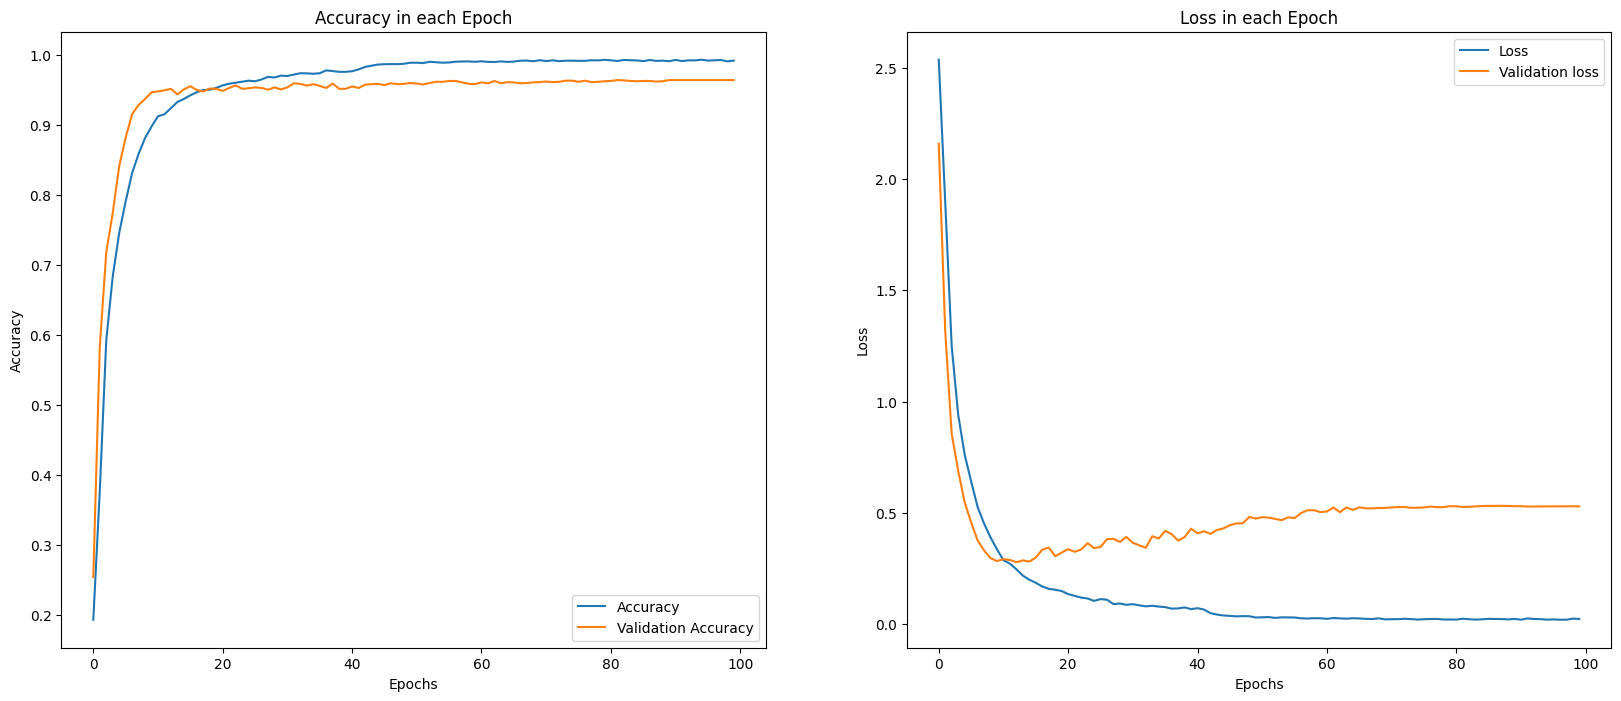

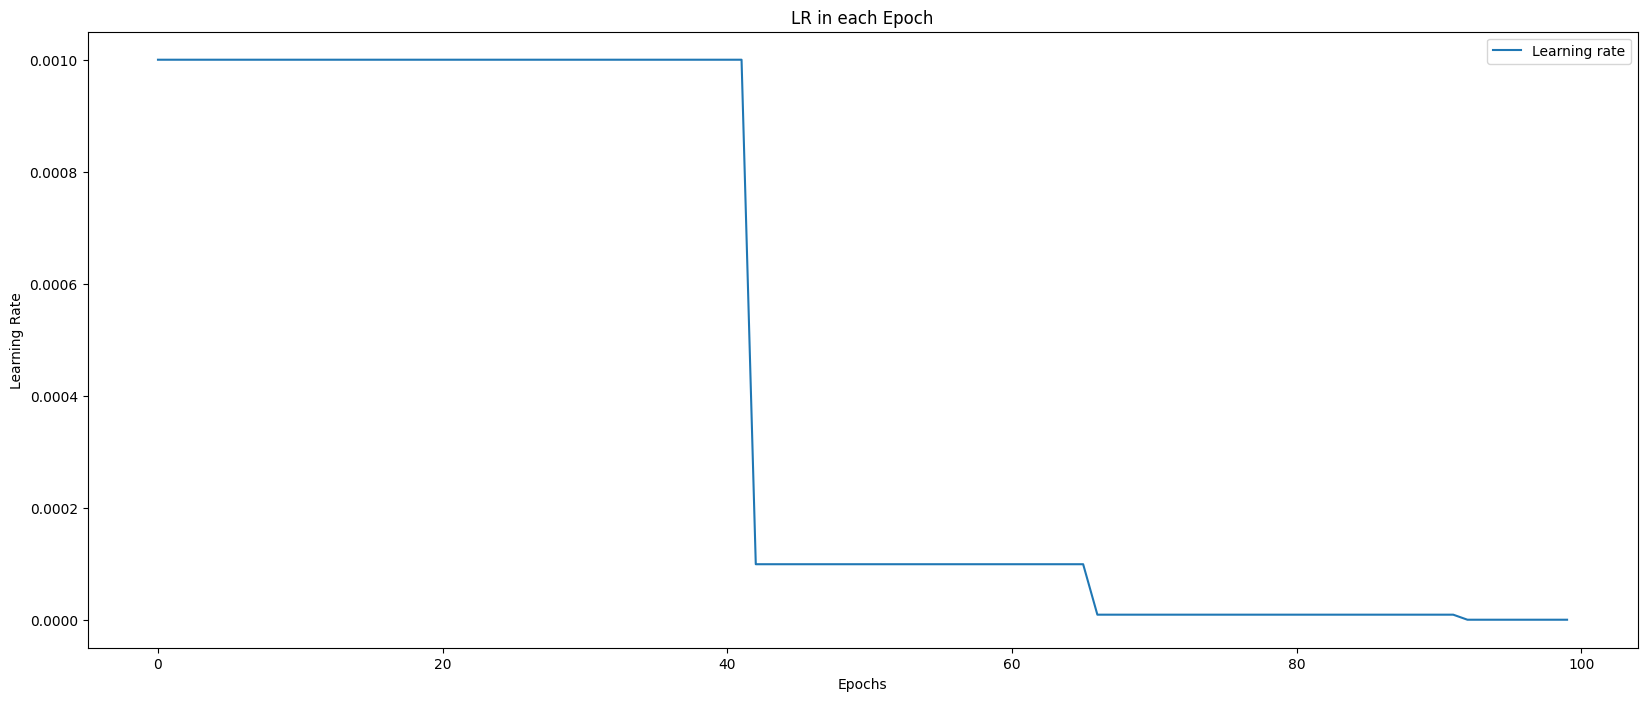

In [17]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(hitory.history['accuracy'], label='Accuracy')
plt.plot(hitory.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy in each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(hitory.history['loss'], label='Loss')
plt.plot(hitory.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss in each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show();
plt.figure(figsize=(20, 8))
plt.plot(hitory.history['learning_rate'], label='Learning rate')
plt.legend()
plt.title('LR in each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show();

In [18]:
images = [os.path.join(base_path, path) for path in os.listdir(base_path)]
np.random.shuffle(images)
test_images = images[:16]
test_labels = [test_image.split('/')[4].split('_')[0] for test_image in test_images]

In [19]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.map(encode_single_sample)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
pred_labels = np.argmax(model.predict(test_dataset), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


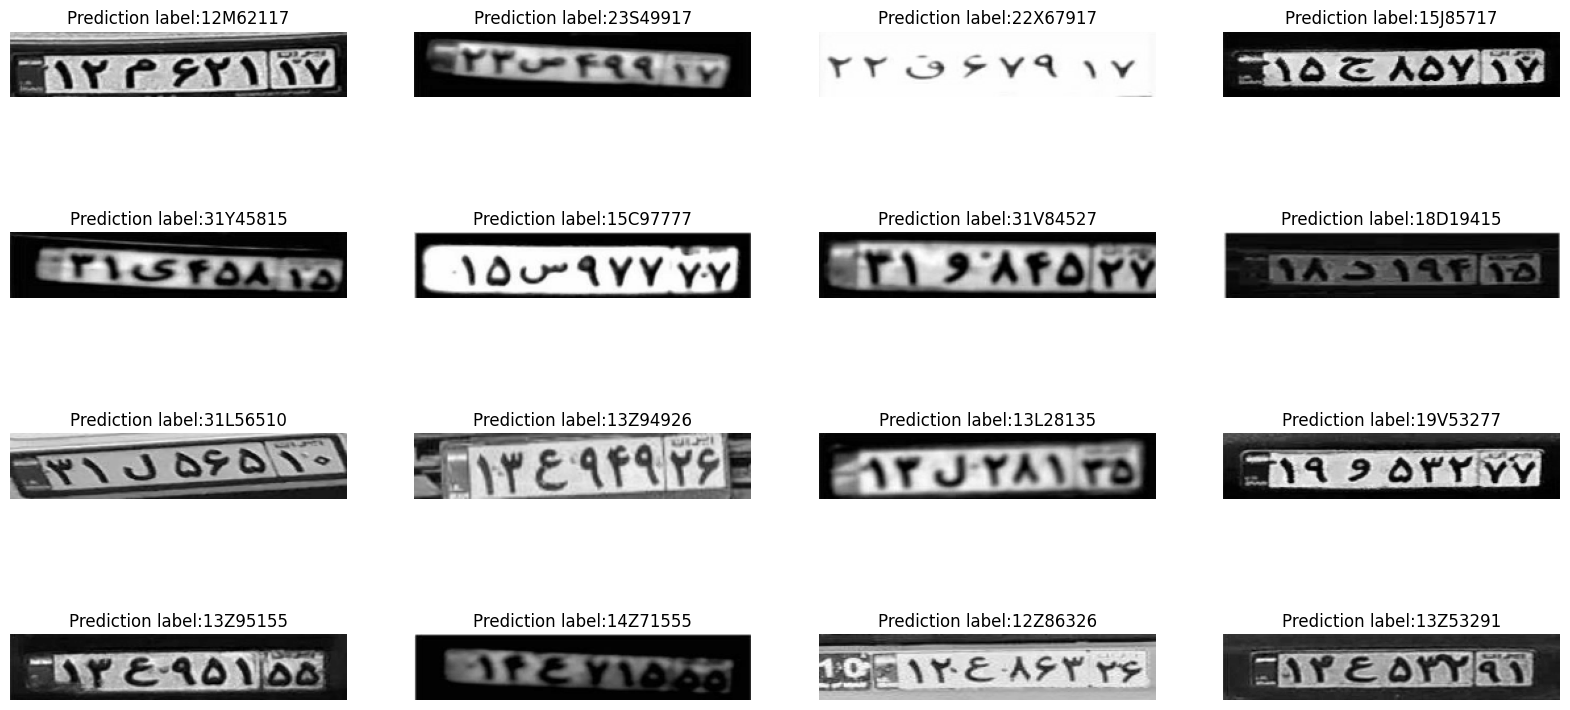

In [21]:
batch_data = next(iter(test_dataset))
images, _ = batch_data
_, axes = plt.subplots(4, 4, figsize=(20, 10))
for i in range(16):
    img = (images[i] * 255).numpy().astype('uint8')
    pred_lbl = tf.strings.reduce_join(num_to_char(pred_labels[i])).numpy().decode('UTF-8')
    axes[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
    axes[i // 4, i % 4].set_title('Prediction label:' + pred_lbl)
    axes[i // 4, i % 4].axis('off')